<a href="https://colab.research.google.com/github/lokesharma-dev/Fake-News-Detection/blob/master/23_06_20_VAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import os
import re
import random
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Text Preprocessing (change with sPacy)

In [ ]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

# Load & Split Data

## npy

In [ ]:
# # Imdb Dataset
# x_train = np.load('/content/drive/My Drive/Colab Notebooks/Imdb/x_train.npy').astype('int32')
# y_train = np.load('/content/drive/My Drive/Colab Notebooks/Imdb/y_train.npy').astype('int32')
# MAX_SEQ_LENGTH = 300
# VOACB_SIZE = 79094
# EMBEDDING_DIM = 256
# BATCH_SIZE = 2048

# # Spacy Dataset
# x_train = np.load('/content/drive/My Drive/Colab Notebooks/npy/data.npy').astype('int32')
# y_train = np.load('/content/drive/My Drive/Colab Notebooks/npy/label.npy').astype('int32')
# MAX_SEQ_LENGTH = 500
# VOACB_SIZE = 12186
# EMBEDDING_DIM = 256
# BATCH_SIZE = 40

# inds = np.arange(x_train.shape[0])
# random.Random(1).shuffle(inds)
# data = x_train[inds]
# labels = y_train[inds]

# num_test_samples = int(0.2 * data.shape[0])
# print('Split ratio {}/{}:'.format(num_test_samples, data.shape[0]))
# x_train = data[:-num_test_samples]
# y_train = labels[:-num_test_samples]
# x_test = data[-num_test_samples:]
# y_test = labels[-num_test_samples:]
# print("Training size:", x_train.shape, y_train.shape)
# print("Testing size:", x_test.shape, y_test.shape)

## txt

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Imdb/x_train.txt'
with open(path, 'r') as file:
  x_train = file.readlines()

df = pd.DataFrame(x_train, columns=['Subject'])
print('Before cleaning',df.head())

df['Subject'] = df['Subject'].map(lambda x: clean_text(x))
print('After cleaning', df.head())

Before cleaning                                              Subject
0  Working with one of the best Shakespeare sourc...
1  Well...tremors I, the original started off in ...
2  Ouch! This one was a bit painful to sit throug...
3  I've seen some crappy movies in my life, but t...
4  "Carriers" follows the exploits of two guys an...
After cleaning                                              Subject
0  work one best shakespear sourc film manag cred...
1  well tremor origin start 1990 found movi quit ...
2  ouch ! one bit pain sit through cute amus prem...
3  i have seen crappi movi life one must among wo...
4  carrier follow exploit two guy two gal stolen ...


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Subject'])
train_sequences = tokenizer.texts_to_sequences(df['Subject'])
x_train = pad_sequences(train_sequences, maxlen=300, padding='post')
type(x_train), len(x_train)
vocab = tokenizer.word_index
len(vocab)

52207

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Imdb/y_train.npy'
y_train = np.load(path).astype('int32')
type(y_train), len(y_train)

(numpy.ndarray, 24999)

In [ ]:
inds = np.arange(x_train.shape[0])
random.Random(1).shuffle(inds)
data = x_train[inds]
labels = y_train[inds]

num_test_samples = int(0.2 * data.shape[0])
print('Split ratio {}/{}:'.format(num_test_samples, data.shape[0]))
x_train = data[:-num_test_samples]
y_train = labels[:-num_test_samples]
x_test = data[-num_test_samples:]
y_test = labels[-num_test_samples:]
print("Training size:", x_train.shape, y_train.shape)
print("Testing size:", x_test.shape, y_test.shape)

Split ratio 4999/24999:
Training size: (20000, 300) (20000,)
Testing size: (4999, 300) (4999,)


## Convert to tf.data.Dataset

In [ ]:
BATCH_SIZE = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(len(x_train), seed=1, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(len(x_test), seed=1, reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Create Embedding Matrix

In [ ]:
EMBEDDING_FILE = '/content/drive/My Drive/Colab Notebooks/Imdb/glove.6B.50d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

In [ ]:
embedding_matrix = np.zeros((len(vocab) + 1, 50))
invalid = 0
for word, index in vocab.items():
  if index > len(vocab) - 1:
    break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector
    else:
      embedding_matrix[index] = np.random.uniform(low=0.01, high=0.05, size=50)
      invalid += 1
print('Words not found in glove: ', invalid)

Words not found in glove:  20951


# Custom Training

Build Model

In [ ]:
features, labels = next(iter(train_dataset))
features, labels

(<tf.Tensor: shape=(1024, 300), dtype=int32, numpy=
 array([[  205,  6817,   940, ...,     0,     0,     0],
        [  829, 15352,   603, ...,     0,     0,     0],
        [   55,   137,   101, ...,     0,     0,     0],
        ...,
        [   30,   151,     3, ...,     0,     0,     0],
        [  337, 10143,   134, ...,     0,     0,     0],
        [   51,   712,   761, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(1024,), dtype=int32, numpy=array([0, 0, 0, ..., 1, 1, 1], dtype=int32)>)

In [ ]:
def create_model(embedding_matrix):
  model = Sequential()
  model.add(Embedding(input_dim=len(vocab) + 1,
                      output_dim=50,
                      weights = [embedding_matrix],
                      trainable=False))
  model.add(LSTM(units=128))
  model.add(Dense(units=32, activation='relu'))
  model.add(Dense(units=2, activation='relu'))
  return model

In [ ]:
model = create_model(embedding_matrix)
predictions = model(features)
predictions, tf.nn.softmax(predictions)

(<tf.Tensor: shape=(1024, 2), dtype=float32, numpy=
 array([[0.0000000e+00, 1.8588254e-17],
        [0.0000000e+00, 5.5379010e-15],
        [0.0000000e+00, 1.3779952e-18],
        ...,
        [0.0000000e+00, 4.2238909e-13],
        [0.0000000e+00, 3.8288585e-19],
        [0.0000000e+00, 1.3334835e-04]], dtype=float32)>,
 <tf.Tensor: shape=(1024, 2), dtype=float32, numpy=
 array([[0.5       , 0.5       ],
        [0.5       , 0.5       ],
        [0.5       , 0.5       ],
        ...,
        [0.5       , 0.5       ],
        [0.5       , 0.5       ],
        [0.49996665, 0.5000333 ]], dtype=float32)>)

In [ ]:
print('Prediction: {}'.format(tf.argmax(predictions[:50], axis=1)))
print('Labels: {}'.format(labels[:50]))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1]
Labels: [0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1
 1 1 1 0 0 0 0 1 0 0 1 1 0]


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
def loss(model, x, y):
  y_ = model(x)
  return loss_object(y_true=y, y_pred=y_)

# l = loss(model, features, labels)
# print('Loss :{}'.format(l))

In [ ]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:

# loss_value, grads = grad(model, features, labels)

# print('Step: {}, Initial Loss: {}'.format(optimizer.iterations.numpy(), loss_value.numpy()))

# optimizer.apply_gradients(zip(grads, model.trainable_variables))

# print('Step: {} Loss: {}'.format(optimizer.iterations.numpy(),
#                                  loss(model, features, labels).numpy()))

# optimizer.apply_gradients(zip(grads, model.trainable_variables))

# print('Step: {} Loss: {}'.format(optimizer.iterations.numpy(),
#                                  loss(model, features, labels).numpy()))

# optimizer.apply_gradients(zip(grads, model.trainable_variables))

# print('Step: {} Loss: {}'.format(optimizer.iterations.numpy(),
#                                  loss(model, features, labels).numpy()))


Tailored

In [ ]:
train_loss_results = []
train_accuracy_results = []
num_epochs = 20

for epoch in range(num_epochs):
  epoch_avg_loss = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  for x, y in train_dataset:
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    epoch_avg_loss.update_state(loss_value)
    epoch_accuracy.update_state(y, model(x, training=True))

  train_loss_results.append(epoch_avg_loss.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 2 == 0:
    print('Epoch {}: Loss {}: Accuracy {}:'.format(epoch,
                                                  epoch_avg_loss.result(),
                                                  epoch_accuracy.result()))

Epoch 0: Loss 0.6936121582984924: Accuracy 0.5092999935150146:
Epoch 2: Loss 0.6931333541870117: Accuracy 0.5003499984741211:
Epoch 4: Loss 0.6901241540908813: Accuracy 0.5117499828338623:
Epoch 6: Loss 0.6901676058769226: Accuracy 0.5277500152587891:
Epoch 8: Loss 0.6891576051712036: Accuracy 0.5130000114440918:
Epoch 10: Loss 0.6906387209892273: Accuracy 0.5091500282287598:
Epoch 12: Loss 0.6926060914993286: Accuracy 0.5024999976158142:
Epoch 14: Loss 0.6928723454475403: Accuracy 0.5006499886512756:
Epoch 16: Loss 0.6930708289146423: Accuracy 0.4995500147342682:
Epoch 18: Loss 0.6932064294815063: Accuracy 0.49950000643730164:


# VAT Model

In [ ]:
features, labels = next(iter(train_dataset))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM
from tensorflow.keras.models import Model

In [ ]:
def createEmbedding(features):
  seq = Input(shape=(300,))
  emb = Embedding(input_dim=len(vocab)+1,
                  output_dim = 50,
                  weights = [embedding_matrix],
                  trainable=False)(seq)
  emb_model = Model(seq, emb)
  clean_emb = emb_model(features)
  return clean_emb

In [ ]:
clean_features = createEmbedding(features)
type(clean_features), clean_features.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([1024, 300, 50]))

In [ ]:
noised_features = tf.add(clean_emb, 0.01)
noised_features = tf.add(noised_features, clean_emb)
type(noised_features), noised_features.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([1024, 300, 50]))

In [ ]:
def createModel(embedding_features):
  emb_tensor = Input(shape=(300,50,))
  hidden = LSTM(units=128)(emb_tensor)
  output = Dense(units=32, activation='relu')(hidden)
  model = Model(inputs=emb_tensor, outputs=output)
  logits = model(embedding_features)
  return emb_tensor, output, logits

In [ ]:
clean_ip_tensor, clean_op_tensor, p_logit = createModel(clean_features)
type(p_logit), p_logit.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([1024, 32]))

In [ ]:
noise_ip_tensor, noise_op_tensor, p_logit_r = createModel(noised_features)
type(p_logit_r), p_logit_r.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([1024, 32]))

In [ ]:
def compute_kld(p_logit, q_logit):
  p = tf.nn.softmax(p_logit)
  q = tf.nn.softmax(q_logit)
  kl_score = tf.reduce_sum( p * (tf.math.log(p+1e-16) - tf.math.log(q+1e-16)), axis = 1)
  return kl_score

In [ ]:
def calculateGradient(clean_features, noised_features):
  
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(noised_features)
    _, _, p_logit = createModel(clean_features)
    _, _, p_logit_r = createModel(noised_features)
    kl_score = compute_kld(p_logit, p_logit_r)
  grads = tape.gradient(kl_score, noised_features)
  return grads

In [ ]:
grads = calculateGradient(clean_features, noised_features)

In [ ]:
norm_ball = tf.math.l2_normalize(grads, axis=None, epsilon=1e-12, name=None)
type(norm_ball), norm_ball.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([1024, 300, 50]))

In [ ]:
rvadv = (grads/norm_ball) * -1
rvadv

In [ ]:
vadv_features = clean_emb + rvadv
vadv_features[0][0] == clean_emb[0][0] +rvadv[0][0]

(<tf.Tensor: shape=(50,), dtype=float32, numpy=
 array([-0.14337596,  0.38108003, -0.22122997, -0.50428   ,  1.59571   ,
         0.35436   , -0.42161998,  0.20172004, -0.15486997,  0.05879004,
        -0.15746996,  0.10282004, -0.70294994,  0.50155   ,  0.54692006,
        -0.51176995,  0.06948003,  0.59549004, -0.75846994,  0.19048004,
        -0.87803996,  1.22301   , -0.01596897,  0.24451004,  0.34211   ,
        -2.85839   , -0.7564399 ,  0.36161003,  0.34041005, -0.34028998,
         2.56341   , -0.39474997, -0.21730997,  0.20255004,  0.26317   ,
         0.26740003,  0.07640003, -0.06163597,  0.17398003, -0.61484   ,
        -0.13525397,  0.57650006, -0.10658997,  0.24476002,  0.61106   ,
        -0.58013994, -0.53132   , -1.02824   ,  0.48236006, -0.16623998],
       dtype=float32)>, <tf.Tensor: shape=(50,), dtype=float32, numpy=
 array([-0.094386,  0.43007 , -0.17224 , -0.45529 ,  1.6447  ,  0.40335 ,
        -0.37263 ,  0.25071 , -0.10588 ,  0.10778 , -0.10848 ,  0.15181 ,
  

In [ ]:
vadv_features[0][0] == clean_emb[0][0] + rvadv[0][0]

<tf.Tensor: shape=(50,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])>

In [ ]:
vat_ip_tensor, vat_op_tensor, q_logit = createModel(vadv_features)

vat_loss = compute_kld(p_logit, q_logit)
vat_loss.shape, vat_loss



(TensorShape([1024]), <tf.Tensor: shape=(1024,), dtype=float32, numpy=
 array([0.00015645, 0.00015645, 0.00015645, ..., 0.00015645, 0.03032912,
        0.00015645], dtype=float32)>)

In [ ]:
(vat_loss.numpy()[:10])

array([0.00015645, 0.00015645, 0.00015645, 0.00015645, 0.00015645,
       0.00015645, 0.00015645, 0.00015647, 0.00015645, 0.00015645],
      dtype=float32)

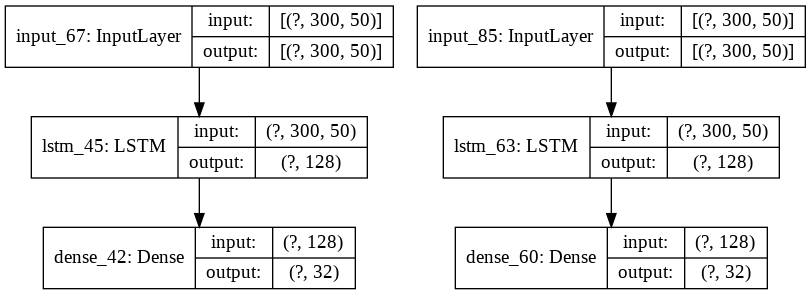

In [ ]:
/model = Model(inputs=[clean_ip_tensor, vat_ip_tensor], outputs=[clean_op_tensor, vat_op_tensor])
# model.summary()
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

FGSM

40960/35363 [==================================] - 0s 0us/step


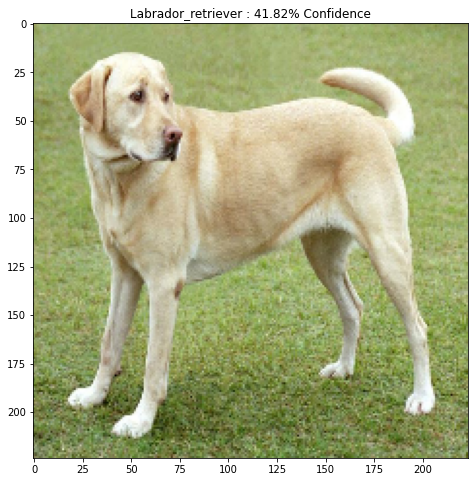

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

plt.figure()
plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [ ]:
input_image

NameError: ignored

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

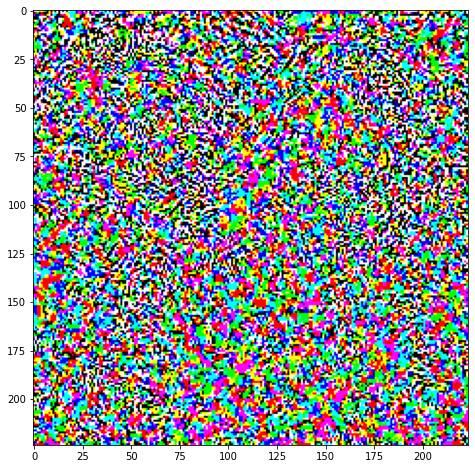

In [ ]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

In [ ]:
type(noised_features), type(image), type(noise_emb_tensor), type(label)

(tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.Tensor,
 tensorflow.python.framework.ops.EagerTensor)

In [ ]:
noise_emb_tensor_x = Input(shape=(300,50,))
type(noise_emb_tensor_x)

tensorflow.python.framework.ops.Tensor

In [ ]:
x = tf.convert_to_tensor(noise_emb_tensor_x)

In [ ]:
type(x)

tensorflow.python.framework.ops.Tensor

In [ ]:
type(seq)

tensorflow.python.framework.ops.Tensor

In [ ]:
x = [[2.]]
m = tf.add(x, x)
type(x), type(m)

(list, tensorflow.python.framework.ops.EagerTensor)

In [ ]:
model = create_model(embedding_matrix)
print(model.summary())
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-1),
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 50)          2610400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_15 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 2,706,209
Trainable params: 95,809
Non-trainable params: 2,610,400
_________________________________________________________________
None


Currently train on 5000 records and 1000 test for evaluation

In [ ]:
history = model.fit(x_train[:5000], y_train[:5000], epochs=2, batch_size=100)

Epoch 1/2
50/50 [==============================] - 30s 607ms/step - loss: 0.6935 - accuracy: 0.5102
Epoch 2/2
50/50 [==============================] - 30s 606ms/step - loss: 0.6931 - accuracy: 0.5102


Plot History

In [ ]:
predictions = model.evaluate(x_test[:1000], y_test[:1000])
predictions

32/32 [==============================] - 3s 89ms/step - loss: 0.6931 - accuracy: 0.5270


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# noise_emb = tf.random_uniform_initializer(minval=0.1, maxval=0.5, seed=0)
def make_noise(seq_length, dimensions, initializer):
  return tf.Variable(initializer(shape=[seq_length, dimensions,], dtype='float32'))
noise_emb = make_noise(300, 50, tf.random_uniform_initializer(minval=0.1, maxval=0.5, seed=0))
noise_emb